# Titanic Passenger Survival Prediction

This notebook contains the data preparation and training of a logistic regression model that predicts the survival of passengers based on the Kaggle dataset "The Complete Titanic Dataset."

It includes the following tasks:

Handling Missing Values:

Various techniques are employed to address missing data, such as feature deletion and imputing missing values using the mean, median, or other appropriate strategies based on feature relationships.

Encoding Categorical Variables:

Categorical variables are transformed into numerical formats using methods like one-hot encoding and label encoding to make them suitable for the logistic regression model.

Feature Scaling:

Features are scaled using StandardScaler to ensure that all numerical features have a comparable scale,with the objective of improving the performance of the logistic regression.

Feature Selection:

The least relevant features are dropped based on correlation analysis. The Variance Inflation Factor (VIF) is used to detect multicollinearity and identify features that are highly correlated with others. The VarianceThreshold is used to eliminate features with low variance, which are less informative and could add noise to the model. 


Model Training:

A logistic regression model is trained on the prepared data and evaluated using accuracy, AUC, and other performance metrics.

In [16715]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt  
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split  
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc



TO DOS:

survival dist

survival by class, gender, todo

Age distribution

boxplot -> classes

embarked 

final summary -> responder pregunta de sus slides

MANAGING MISSING VALUES

plot de missing values

ORIGINAL, STANDARDIZE Y NORMALIZE -> fare



CREATIVA

presentacion de datos finales

ROC Curve

confusion matrix

tabla con tipo de encoder y justificacion

In [16716]:

#cuanta gente tiene floating point sin ser aquellos de 0 a 1
#como solo importa en age si sobreviviste si sos muy chico o muy grande capaz es mejor hacer distintos grupos -> corroborar con la diferencia entre survived y deceased en cada age
#Ver que hacer con fate (lo mismo que age)

#Hacer un loop que pruebe todas las combinaciones posibles y me diga cual es la mejor combinacion 
#L1 regularization y te da los features necesarios -> ponerle todas hasta las nuevas columnas creadas

## 1.  Data Loading and Initial Exploration 


This section bla bla bla

● Are data accessible?


○ Existence: the dataset is available in an Excel format.

○ Access to the data: it has been downloaded from Kaggle, a well-known platform for machine-learning datasets

○ Availability: the data has been provided by the professor, so there is no need to generate it.

○ Copyright, Legal permission, anonymity, or redistribution: the dataset license is unknown, its legal status for redistribution and commercialization is unclear. However, since this project is for academic purposes it should be acceptable.

○ Issues of privacy or confidentiality: passengers' information is publicly available over historical records so there are no confidentiality issues.

○ Generation rate: direct or by proxy (e.g., labelers, 3rd party providers): the source is unknown, there has not been updates for 5 years so it might be incomplete or out-of-date.

● Do we know whether data are reliable? Can we trust the labels? 
According to Wikipedia there were 2,225 passengers aboard the RMS Titanic, which sank after colliding with an iceberg in the Atlantic Ocean while en route to New York City. Only 712 of the 2,225 people on board (counting passengers and crew) survived.


○ We can perform (manual, automated) validation of quality on a subset of the data.
○ Are labels delayed? We observe labels now but use them to predict far future events.
○ Are labels indirect? Indicates a weak correlation with the prediction target (e.g., page interest)

#### 1.1 OVERVIEW

Dependent Variable: Survived

Independent variables: name, sex, age, sibsp, parch, ticket, fate, cabin, embarked, boat, body, home.dest.

In [16717]:
df = pd.read_excel('titanic3.xls')
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [16718]:
df.tail(5) 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


**Categorical Features:**


    survival: 
Survival status (0 = No, 1 = Yes). 

Categorical (Binary: 0 or 1)


    class: 
Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd).

Categorical (Ordinal: 1st, 2nd, 3rd class)


    name: 
Name.

Categorical (Text, Identifier)


    sex: 
Sex.

Categorical (Nominal: Male, Female)

    ticket: 

Ticket Number.

Categorical (Text, Identifier)

    cabin: 
Cabin.

Cabin is conformed of letters and numbers. Apparently the letter represents the deck where the cabin was located at.

Categorical (Text, Identifier)

    embarked: 
Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton).
Categorical (Nominal: C, Q, S)

    boat: 
Lifeboat (if survived).

Categorical (Nominal: Yes or No, or a specific boat number)

    body: 
Body number (if did not survive and the body was recovered).

Categorical (Identifier, could be numeric but represents a categorical feature)

**Numerical Features:**

    sibsp: 
Number of Siblings/Spouses Aboard.

Numerical (Discrete: Integer)

    parch: 
Number of Parents/Children Aboard.

Numerical (Discrete: Integer)

    fare: 
Passenger Fare.

Numerical (Continuous: Float/Decimal)

In [16719]:
df.shape

(1309, 14)

In [16720]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [16721]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 14)


In [16722]:
df.nunique()

pclass          3
survived        2
name         1307
sex             2
age            98
sibsp           7
parch           8
ticket        939
fare          281
cabin         186
embarked        3
boat           28
body          121
home.dest     369
dtype: int64

In [16723]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


#### 1.2 VISUALIZATIONS AND EXPLORATORY STATISTICS

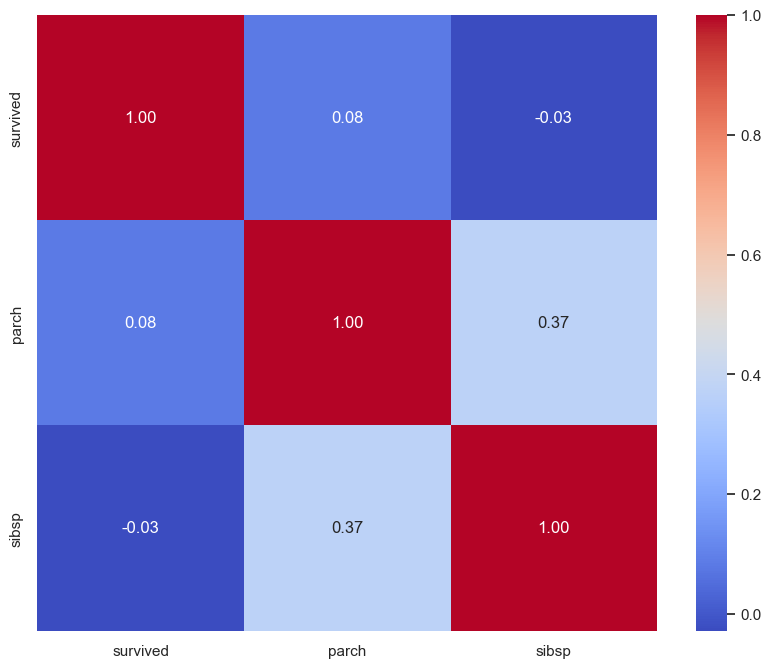

In [16724]:
selected_columns = ['survived', 'parch', 'sibsp']

df_selected = df[selected_columns]

# Calcular la matriz de correlación entre las columnas seleccionadas
correlation_matrix = df_selected.corr()

# Visualizar la matriz de correlación con un heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

#### Plots

Numerical variables: age, sibsp, parch, fate
Categorical variables: survived, pclass, sex, ticket, cabin, embarked

In [16725]:
#Letter extraction from cabin and missing values
df_subset = df["cabin"].dropna().astype(str).str[0]  # first letter
df_subset.head()

0    B
1    C
2    C
3    C
4    C
Name: cabin, dtype: object

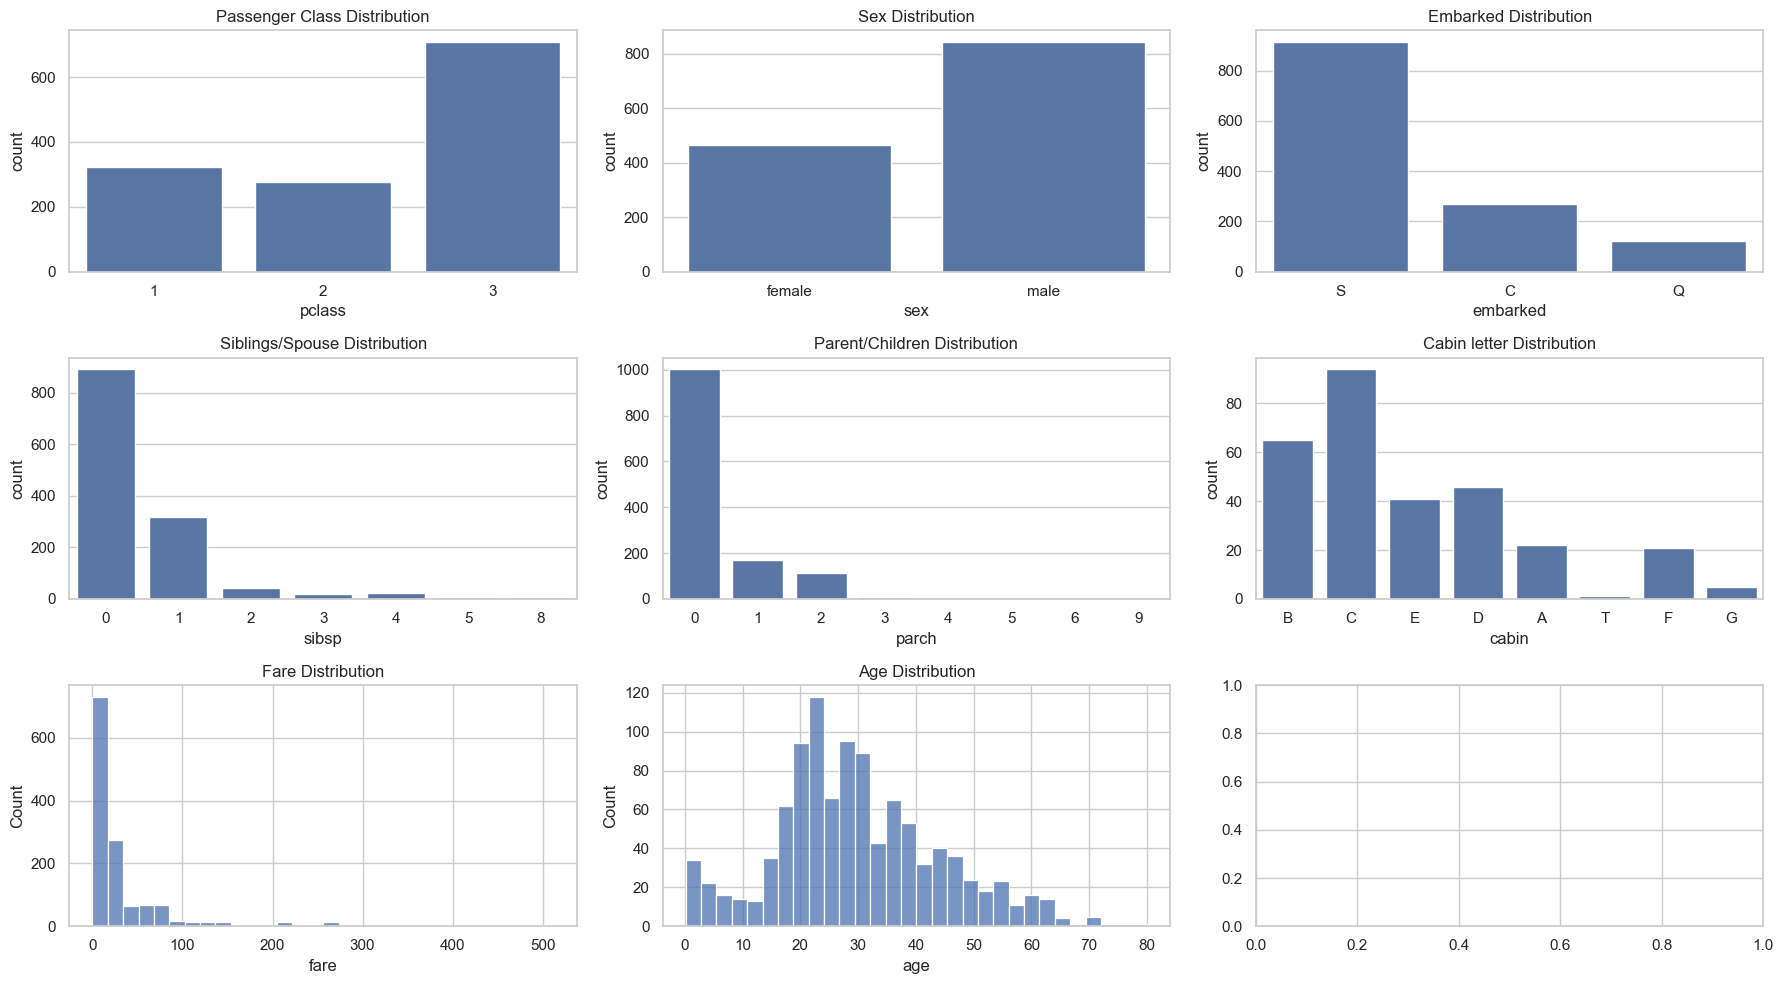

In [16726]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 10))

# Distribution Pclass
sns.countplot(x='pclass', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Passenger Class Distribution')

# Distribution Sex
sns.countplot(x='sex', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Sex Distribution')

# Distribution Embarked
sns.countplot(x='embarked', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Embarked Distribution')

#Distribution siblings/spouses
sns.countplot(x='sibsp', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Siblings/Spouse Distribution')

#Distribution parent/children
sns.countplot(x='parch', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Parent/Children Distribution')

#Distribution cabin by letter
sns.countplot(x=df_subset, ax=axes[1, 2])
axes[1, 2].set_title('Cabin letter Distribution')

# Distribution Fare
sns.histplot(df['fare'].dropna(), bins=30, ax=axes[2, 0])
axes[2, 0].set_title('Fare Distribution')

# Distribution Age
sns.histplot(df['age'].dropna(), bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Age Distribution')


plt.tight_layout()
plt.show()


ANALYSIS:

Understanding the distribution and balance of classes:

Since there are aroun 180 cabins in the dataset I have decided to look at the distribution based on the deck where the cabin was located at.


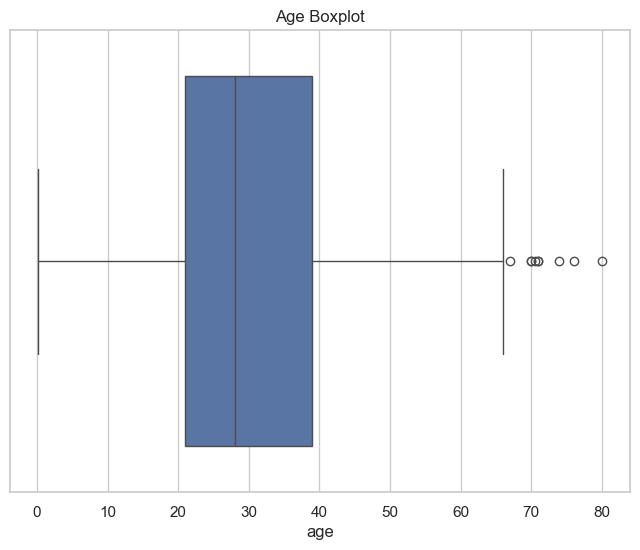

In [16727]:
# Box plot for Fare

# Box plot for Age
plt.figure(figsize=(8, 6))
sns.boxplot(x='age', data=df)
plt.title('Age Boxplot')
plt.show()

COMPARISONS BETWEEN INDEPENDENT VARIABLES AND DEPENDENT VARIABLE

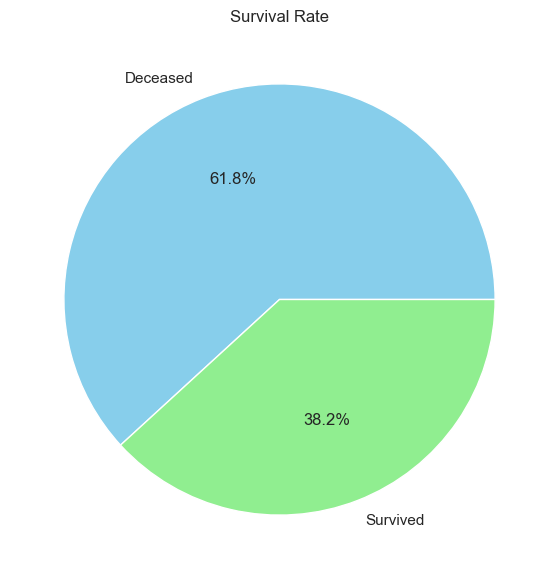

In [16728]:
survival_counts = df['survived'].value_counts()
data = survival_counts.values
labels = ['Deceased', 'Survived']

fig = plt.figure(figsize=(10, 7))
plt.title("Survival Rate")
plt.pie(data, labels=labels, autopct='%1.1f%%', colors = ['skyblue', 'lightgreen'])

plt.show()

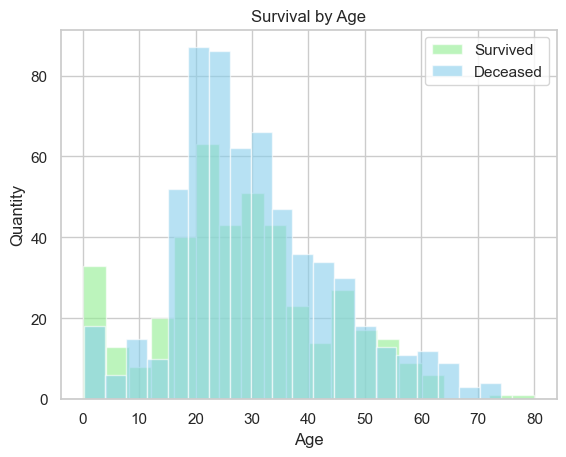

In [16729]:
#Survived
plt.hist(df[df['survived'] == 1]['age'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

# Deceased
plt.hist(df[df['survived'] == 0]['age'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')

plt.xlabel('Age')
plt.ylabel('Quantity')
plt.title('Survival by Age')
plt.legend()
plt.show()

porcentaje del total en vez de quantity porque no representa ya que hay mas deceased que survived

In [16730]:
#VER SI HACER EXPLORATORY ANALYSIS DE FAMILY SIZE ACA O DESPUES


In [16731]:
#df['familysize'] = df['sibsp'] + df['parch'] + 1
#plt.figure(figsize=(8, 6))
#sns.boxplot(x='familysize', data=df, palette=['lightgreen'])
#plt.title('Family Size Box Plot')
#plt.show()


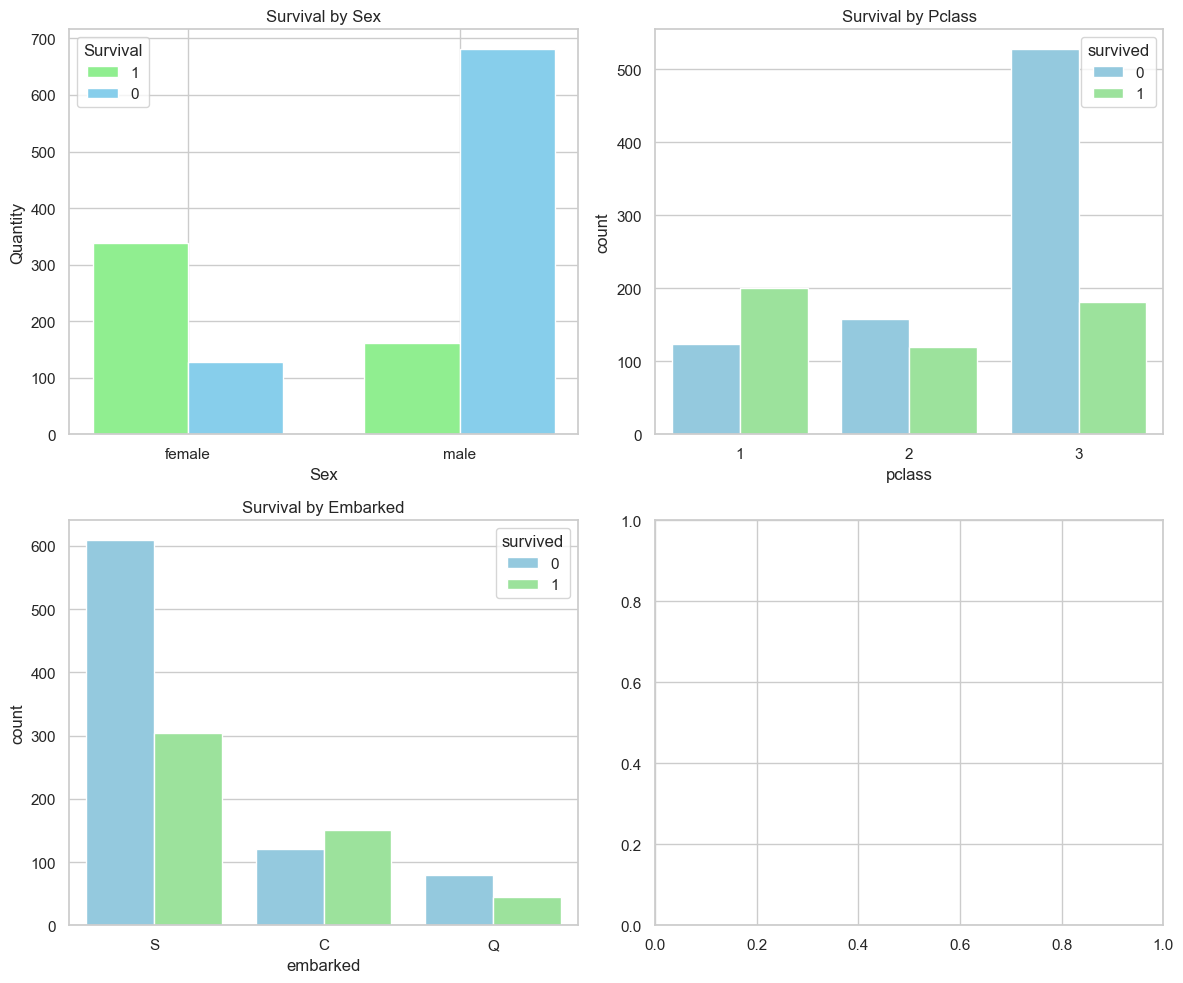

In [16732]:

# Assuming you have already imported and prepared 'df' dataset

# Create a figure with multiple subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Survival by Sex (Bar plot)
counts = df.groupby(['sex', 'survived']).size().unstack()
survived = counts[1]
deceased = counts[0]
bar_width = 0.35
x = np.arange(len(counts.index))

axes[0, 0].bar(x - bar_width/2, survived, bar_width, label='1', color='lightgreen')
axes[0, 0].bar(x + bar_width/2, deceased, bar_width, label='0', color='skyblue')
axes[0, 0].set_xlabel('Sex')
axes[0, 0].set_ylabel('Quantity')
axes[0, 0].set_title('Survival by Sex')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(counts.index)
axes[0, 0].legend(title='Survival')

# Plot 2: Survival by Pclass (Count plot)
sns.countplot(x='pclass', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[0, 1])
axes[0, 1].set_title('Survival by Pclass')

# Plot 3: Survival by Embarked (Count plot)
sns.countplot(x='embarked', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[1, 0])
axes[1, 0].set_title('Survival by Embarked')

# Plot 4: Survival by Family Size (Count plot)
#sns.countplot(x='familysize', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[1, 1])
#axes[1, 1].set_title('Survival by Family Size')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## 2. Missing Values - Features Deletion / 'Unknown'

In [16733]:
#columns with missing values
df.count() 

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [16734]:
missing_val = df.isnull().sum()
missing_percentage = round((missing_val/len(df)) * 100, 2)
table = pd.DataFrame({'Missing Values': missing_val, 'Missing Percentage': missing_percentage})

print(table)

           Missing Values  Missing Percentage
pclass                  0                0.00
survived                0                0.00
name                    0                0.00
sex                     0                0.00
age                   263               20.09
sibsp                   0                0.00
parch                   0                0.00
ticket                  0                0.00
fare                    1                0.08
cabin                1014               77.46
embarked                2                0.15
boat                  823               62.87
body                 1188               90.76
home.dest             564               43.09


#### 2.1 Data Leakage

"boat" and "body" features are direct indicators of survival or not, which are inherently tied to the prediction target. 

The "boat" feature indicates whether a passenger was placed on a lifeboat. It is closely tied to survival, as most passengers who were placed on boats survived. 

As it can be seen in the first block of code, only 9 people placed on lifeboats out of a total of 486 filled records did not survive.

Even though some passengers might have been placed on lifeboats before the ship fully began sinking (and thus before time t, when the survival outcome is finalized), the decision to board a lifeboat already strongly indicates the passenger’s likely survival. Once a passenger is assigned to a lifeboat, survival is essentially guaranteed.

Passengers who were seen alive after the sinking during the evacuation process were also probably assigned to lifeboats. Being placed on a boat was a clear indicator that the person survived.

So, including this feature would give the model access to the outcome during training, causing data leakage.

The "body" feature refers to the body number, which is assigned to passengers who did not survive, revealing the passenger has passed away. Including this feature would directly reveal the outcome (not surviving), again leading to data leakage. 

By eliminating these features directly from the dataset we prevent data leakage, which occurs when the prediction target is implicitly contained in the training dataset. This would lead to an overly optimistic performance and a model that would not be capable of generalizing to unseen data.

In [16735]:
not_survived_on_boats = df[(df['survived'] == 0) & (df['boat'].notnull())]

num_not_survived_on_boats = not_survived_on_boats.shape[0]

print(f"Number of passengers who did not survive and were placed on boats: {num_not_survived_on_boats}")

Number of passengers who did not survive and were placed on boats: 9


In [16736]:
df = df.drop(['body', 'boat'], axis=1)
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


#### 2.2 Home.dest

Strategy chosen: Deletion

The feature home.dest includes a total of 564 missing values. Out of the 745 values present in the dataset 369 of them are unique.
Around 43% of values are missing, and out of those present, almost 50% are unique.

A large proportion of missing values can potentially lead to bias  or noise if filled with the mean or median. Probably affecting the overall model performance.
The fact that almost 50% are unique means that values are quite specific, increasing sparsity of data. This will probably make the model struggle to capture any meaningful pattern.

Moreover, with so many unique categories, encoding them would lead to a very high dimensional dataset that may lead to overfitting because the model would be learning very specific details that do not generalize well to unseen data.

There is also no clear logical reason for why a passenger's home destination  would directly influence their survival. Other variables like gender or age make more sense to include in the model

In [16737]:
df.nunique()

pclass          3
survived        2
name         1307
sex             2
age            98
sibsp           7
parch           8
ticket        939
fare          281
cabin         186
embarked        3
home.dest     369
dtype: int64

In [16738]:
df = df.drop(columns=['home.dest'])

In [16739]:
#check
df.isnull().sum() 

pclass         0
survived       0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

#### 2.3 Cabin

PORQUE SE PUEDE HACER ESTO ANTES DE SPLITTING

no se usa informacion del overall distribution para impute los missing values entonces no hay data leackage

Strategy chosen: Imputation

In data exploration, it was noticed that ticket numbers are not unique and might be related to cabins. It appears that each cabin could correspond to a unique ticket number, or that families traveling together might have been assigned the same cabin.

The first step taken will be to check whether either of these patterns holds true for every record in the dataset or if there are inconsistencies that need to be addressed.

If the pattern holds, ticket or family information could be used to impute the missing cabin values. Since some tickets or families have associated cabin data while others do not, it would be possible to identify the records with complete cabin information and then fill in the missing cabin for records sharing the same ticket number or family name.

In [16740]:
#RELATIONSHIP TICKET-CABIN

# Filter missing values for cabin
df_filtered = df[df['cabin'].notna()]

# Group by ticket and check if all cabin values in each group are the same
ticket_cabin_check = df_filtered.groupby('ticket')['cabin'].nunique()

# Not unique tickets
inconsistent_tickets = ticket_cabin_check[ticket_cabin_check > 1]

print("Number of inconsistencies:")
print(inconsistent_tickets.count())


Number of inconsistencies:
25


Initially, extracting the first word of the 'name' column for comparison was considered. However, some last names consist of multiple words, such as "De La Cruz." Given this, I decided to extract everything up to the first comma to ensure a more accurate representation.

In [16741]:
#RELATIONSHIP FAMILY-CABIN

def extract_last_name(name):
    name_parts = name.split(',')
    last_name = name_parts[0].strip()
    return last_name

last_name_filtered = df['name'].apply(extract_last_name)

last_name_df = df.copy()
last_name_df['last_name'] = last_name_filtered

family_cabin_check = last_name_df.groupby('last_name')['cabin'].nunique()

inconsistent_last_names = family_cabin_check[family_cabin_check > 1]

print("Number of inconsistencies:")
print(inconsistent_last_names.count())

Number of inconsistencies:
16


In the analysis, it was initially assumed that the ticket-cabin relationship could be used to fill in the missing cabin values. However, there are a few inconsistencies that prevent this approach from working reliably. 

Using imputation methods like the mode, median, or mean would not be appropriate. For instance, if the mode were to be used, it would suggest that a large number of passengers share the same cabin, which is unrealistic. Given the high number of missing values, it wouldn't make sense for a substantial portion of the passengers to end up with the same cabin.

The median and mean also fall short because the cabin values include letters. 

Therefore, the missing cabin entries will be filled with "Unknown." 
This decision lies behind the fact that since the first letter of the cabin represents the deck were the cabin was located, that detail could influence survival outcomes, perhaps due to differences in proximity to the lifeboats.

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/3198351460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_cabin_counts.index, y=null_cabin_counts.values, palette='Set2')


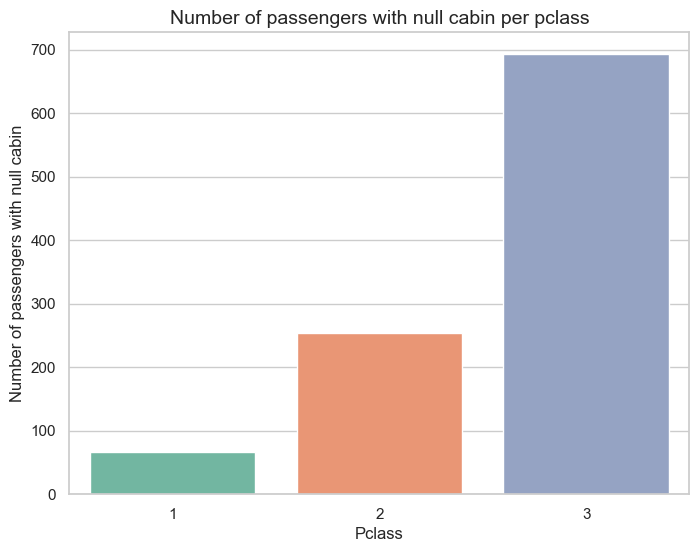

In [16742]:
# Filtrar las filas donde la columna 'cabin' es nula
null_cabin = df[df['cabin'].isnull()]

# Contar cuántos pasajeros con 'cabin' nulo hay en cada clase ('pclass')
null_cabin_counts = null_cabin['pclass'].value_counts()

# Crear el plot
plt.figure(figsize=(8, 6))
sns.barplot(x=null_cabin_counts.index, y=null_cabin_counts.values, palette='Set2')

# Añadir título y etiquetas
plt.title('Number of passengers with null cabin per pclass', fontsize=14)
plt.xlabel('Pclass', fontsize=12)
plt.ylabel('Number of passengers with null cabin', fontsize=12)

# Mostrar el plot
plt.show()

cabin         A          B         C          D          E          F      G  \
pclass                                                                         
1       8.59375  25.390625  36.71875  15.625000  13.281250   0.000000   0.00   
2       0.00000   0.000000   0.00000  26.086957  17.391304  56.521739   0.00   
3       0.00000   0.000000   0.00000   0.000000  18.750000  50.000000  31.25   

cabin          T  
pclass            
1       0.390625  
2       0.000000  
3       0.000000  


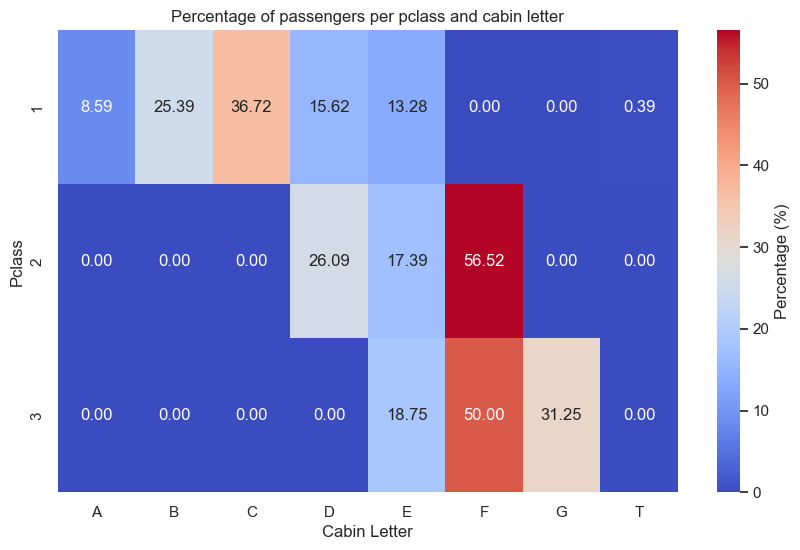

In [16743]:
# Copiar el DataFrame
df_cabin_class = df.copy()

# Extraer la primera letra de la columna 'cabin' y guardarla en una nueva columna 'cabin_letter'
df_cabin_class['cabin'] = df_cabin_class['cabin'].str[0]

# Crear una tabla de contingencia que cuente cuántos pasajeros de cada pclass tienen cada cabina (cabin_letter)
cabin_pclass_count = pd.crosstab(df_cabin_class['pclass'], df_cabin_class['cabin'])

# Calcular el porcentaje de cada cabina por clase dividiendo por el total de cada fila
cabin_pclass_percentage = cabin_pclass_count.div(cabin_pclass_count.sum(axis=1), axis=0) * 100

# Mostrar el resultado de los porcentajes
print(cabin_pclass_percentage)

# Para visualizar, podemos graficar los resultados:
plt.figure(figsize=(10, 6))
sns.heatmap(cabin_pclass_percentage, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Percentage (%)'})
plt.title('Percentage of passengers per pclass and cabin letter')
plt.xlabel('Cabin Letter')
plt.ylabel('Pclass')
plt.show()


High cabin letters, like ABC, are more commonly associated with pclass. Cabins starting with C make up most of pclass 1. This suggests that first-class passengers occupy cabins located in higher or more exclusive areas of the ship.

Cabin F is the most popular cabin for pclass 2 passengers, with 56.52% of second-class passengers occupying these cabins. While cabin D still has a considerable amount of class 2 passengers, F tends to have a higher occupation.

Regarding class 3, they occupy cabins from E to G, which are located in the lowest parts in the ship.

Pointing out a clear relationship between pclass and cabin letter.

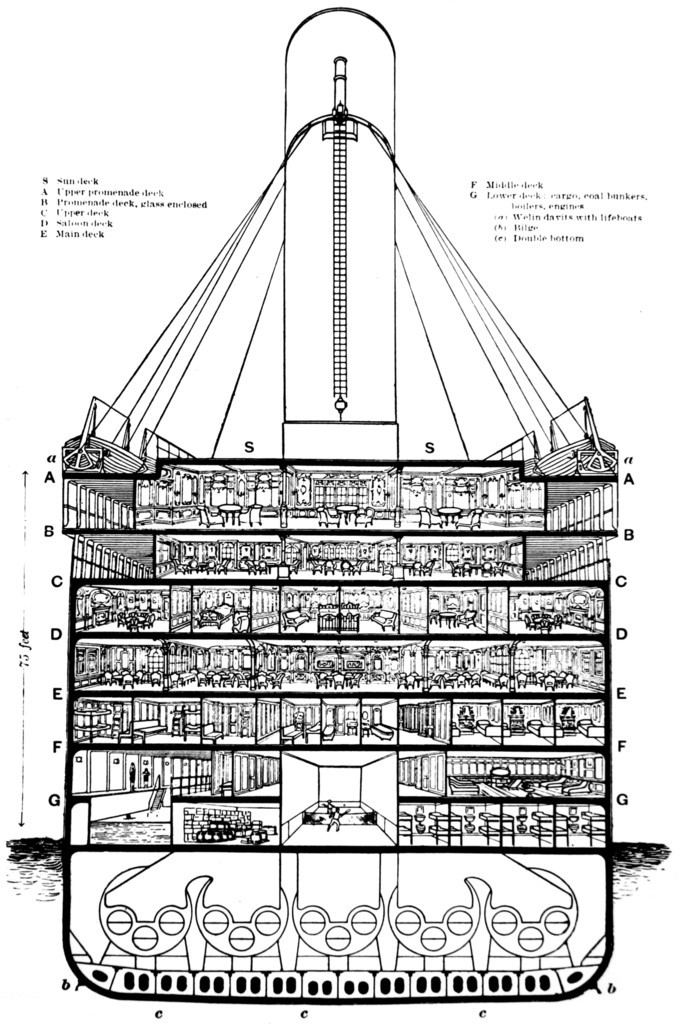



In [16744]:
df['cabin'] = df['cabin'].fillna('Unknown')
df['cabin'].isnull().sum()

np.int64(0)

In [16745]:
df.head(12)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,Unknown,C


#### 2.4 Ticket

Ticket numbers seem to be arbitrary, therefore having no predictive power on survival. Inlcuding it in the model would probably only introduce noise. Moreover, ticket consists of alphanumeric values and has a high number of unique values, making it difficult to encode efficiently. 

Despite tickets coild include useful group-based information, such as families traveling together, this information is already captured "sibsp" and "parch". Keeping unnecessary features can lead to overfitting and inefficient model performance. 

In [16746]:
#RELATIONSHIP FAMILY-TICKET

def extract_last_name(name):
    name_parts = name.split(',')
    last_name = name_parts[0].strip()
    return last_name

last_name_filtered = df['name'].apply(extract_last_name)

last_name_df = df.copy()
last_name_df['last_name'] = last_name_filtered

family_cabin_check = last_name_df.groupby('last_name')['ticket'].nunique()

inconsistent_last_names = family_cabin_check[family_cabin_check > 1]

print("Number of inconsistencies:")
print(inconsistent_last_names.count())

Number of inconsistencies:
103


Out of 1,309 passengers only 103 inconsistencies exist (where the same ticket number does not align with family names), then this suggests a high correlation with family features (sibsp and parch).

If most passengers with the same ticket are family members traveling together, then "sibsp" (siblings/spouses) and "parch" (parents/children) already capture this information. The remaining 103 inconsistencies are relatively small (only approximately 8% of the dataset), meaning they likely have little additional predictive value.

Since its influence is mostly captured by sibsp & parch, keeping it would only add complexity.

In [16747]:
df = df.drop(columns=['ticket'])

#### 2.5 Fare

The variable fare has a correlation of 0.24 with the target variable, indicating a weak relationship. While passengers who paid higher fares tend to have a slightly higher probability of survival, this correlation is not strong enough.

Additionally, as portrayed in graph 1, fare has a very high variance (51.76 - as explored in section 1) and a right-skewed distribution. This could lead the model to focus too much on outliers, increasing the risk of overfitting and potentially reducing its ability to generalize to new data. 

Furthermore, it shows a very high negative correlation with pclass, another feature included in the model. Including both could introduce multicollinearity.

Given these factors, Fare is excluded from the final model to enhance parsimony, favoring a simpler model without introducing unnecessary complexity, while still preserving predictive power.

*note: the model has also been tested by including fare and imputing the missing value with the median, however, it did not contribute to the learning.

In [16748]:
#median_fare = train_df['fare'].median()

#train_df['fare'] = train_df['fare'].fillna(median_fare)
#validation_df['fare'] = validation_df['fare'].fillna(median_fare)
#test_df['fare'] = test_df['fare'].fillna(median_fare)

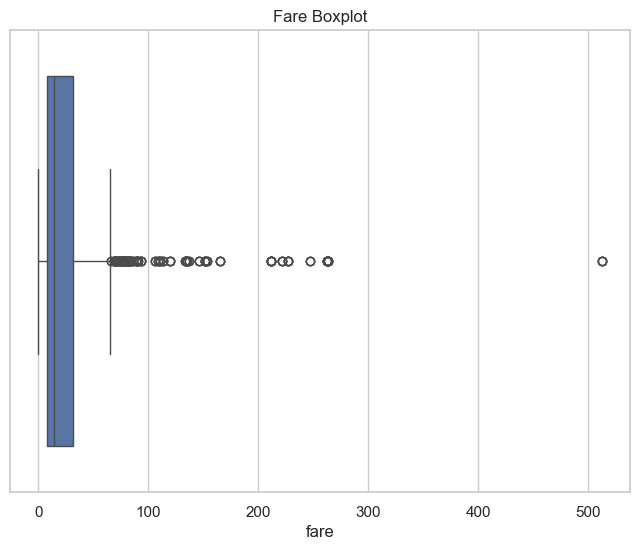

In [16749]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='fare', data=df)
plt.title('Fare Boxplot')
plt.show()

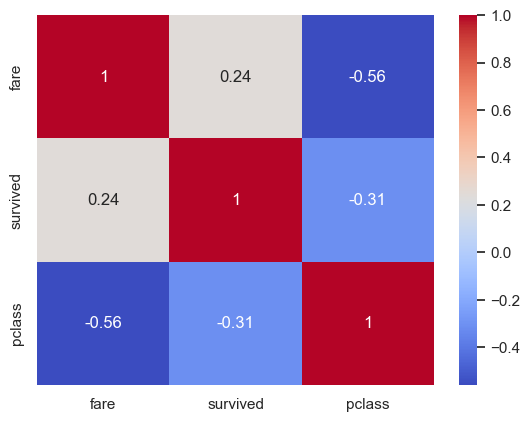

In [16750]:
sns.heatmap(df[['fare', 'survived', 'pclass']].corr(), annot=True, cmap="coolwarm")
plt.show()

In [16751]:
df = df.drop(columns=['fare'])

## 3. Data Splitting

The following section performs the splitting of the data into training, validation and test sets. To ensure a robust evaluation of the model, we first split the dataset into Train (80%) and Others (20%), where "Others" is later divided into Validation (10%) and Test (10%). This two-step splitting process helps prevent data leakage, ensuring that no information from the validation or test sets influences model training. This guarantees that the model does not "see" validation or test data while it trains.

Additionally, this approach allows for better class stratification, preserving the original distribution of labels across all subsets, which is crucial for imbalanced datasets. This method leads to a more generalizable and unbiased performance evaluation.

The decision behind the 80-10-10 division lies in providing a large enough amount of data for the model to learn representative patterns effectively while reducing overfitting. With a small to medium sized dataset like the Titanic this division seems to be suitable. A 70-15-15 split reduces the training data, which can harm learning in smaller datasets because the model has fewer examples to learn from, potentially leading to underfitting. On the other hand, a 90-5-5 split may not provide a large enough validation and test set to accurately assess model performance and generalization. A small test set could result in high variance in evaluation metrics meaning that the evaluation results may be unstable and unreliable as small changes in the test data could lead to large variations in the reported performance. This is why, despite noticing an accuracy of 85% with a splitting of 85-7.5-7.5 I have decided to stick to 80-10-10.

To prevent data leaking, the dataset is divided before missing value imputation is performed. The training set remains independent when the data is separated first, enabling imputation to be performed solely on the training data before being applied independently to the validation or test sets. This approach mimics actual situations in which patterns discovered purely from the training data must be used to fill in missing values in new data, preventing the model from learning anything about the test set.

During the first splitting stratification and random_state are specified.

Stratification ensures the distribution of the target variable in the train, validation, and test sets is as similar as possible to the original dataset. Without stratification, there is a risk that the split could result in uneven distributions of the target variable, which would lead to biased training and evaluation. This helps in building a more reliable model that generalizes better.

A random state is set to ensure reproducibility. Ensuring that when the code is executed by different users or in different environments, it produces identical results.

In [16752]:
#Splitting 80-10-10
train_df, others_df = train_test_split(df, test_size=0.2, stratify=df['survived'], random_state=2025)

validation_df, test_df = train_test_split(others_df, test_size=0.5, stratify=others_df['survived'], random_state=2025)

# Distribution in each split -> same as whole dataset
print("Training set distribution:")
print(train_df['survived'].value_counts() / len(train_df))

print("\nValidation set distribution:")
print(validation_df['survived'].value_counts() / len(validation_df))

print("\nTest set distribution:")
print(test_df['survived'].value_counts() / len(test_df))

Training set distribution:
survived
0    0.617956
1    0.382044
Name: count, dtype: float64

Validation set distribution:
survived
0    0.618321
1    0.381679
Name: count, dtype: float64

Test set distribution:
survived
0    0.618321
1    0.381679
Name: count, dtype: float64


## 4. Missing Values - Imputation

After splitting the data, we can now proceed with imputing missing values.

Imputation of missing values should be performed after splitting the data into training, validation, and test sets to avoid data leakage. If imputation is done before splitting, information from the validation or test set would be used to fill in missing values in the training set, which would bias the model and lead to overfitting. This would give the model knowledge of the unseen data, making it perform unrealistically well on the test set.

The imputation of missing values is based only on the train set and applied to train, validation and test sets. 
This means the imputation for validation and test sets are based on the statistics derived from the training set, as this is what the model would experience in real-world deployment.

Ensuring there is no data leackage and that the three data sets are processed consistently.

#### 4.1 Embarked

Since there are only two missing values in the variable "Embarked", filling them with the most common port of embarkation ensures that the overall distribution remains nearly unchanged, minimizing the risk of introducing bias. 

Additionally, as "Embarked" is a categorical variable, using the mode, which represents the most frequent category, is a logical choice for imputation.

In [16753]:
missing_embarked = df[df["embarked"].isnull()]
print(missing_embarked)

     pclass  survived                                       name     sex  \
168       1         1                        Icard, Miss. Amelie  female   
284       1         1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      age  sibsp  parch cabin embarked  
168  38.0      0      0   B28      NaN  
284  62.0      0      0   B28      NaN  


In [16754]:
mode_embarked = train_df['embarked'].mode()[0]

train_df['embarked'] = train_df['embarked'].fillna(mode_embarked)
validation_df['embarked'] = validation_df['embarked'].fillna(mode_embarked)
test_df['embarked'] = test_df['embarked'].fillna(mode_embarked)

In [16755]:
print("Missing values in x_train:")
print(train_df.isnull().sum())

print("\nMissing values in x_val:")
print(validation_df.isnull().sum())

print("\nMissing values in x_test:")
print(test_df.isnull().sum())

Missing values in x_train:
pclass        0
survived      0
name          0
sex           0
age         203
sibsp         0
parch         0
cabin         0
embarked      0
dtype: int64

Missing values in x_val:
pclass       0
survived     0
name         0
sex          0
age         29
sibsp        0
parch        0
cabin        0
embarked     0
dtype: int64

Missing values in x_test:
pclass       0
survived     0
name         0
sex          0
age         31
sibsp        0
parch        0
cabin        0
embarked     0
dtype: int64


#### 4.2. Age

As a first approach imputing the mean by sex was considered. However, the correlation between age and sex is 0.07 (heatmap "Correlation between sex and age"), which is a very weak positive relationship. This suggests that sex is not a good predictor for age. 
From the age distribution by sex it does not seem to be a significant difference between female mean age and male mean age, which would lead to approach the imputation using the global mean. However, this may lead to a less accurate representation of the missing values.


As a result, observing the relationship with the pclass feature seems reasonable since pclass represents the socioeconomic status of passengers, which often correlates with age.

As shown in "Age Distribution by Pclass", passangers in pclass 1 tend to be older on average, while passengers in pclass 3 tend to be younger. For Pclass 1, the median age is around 40-45, for Pclass 2, it's closer to 30, and for Pclass 3, it's closer to 25.

This relationship suggests that pclass can serve as a  predictor for missing age values as it would preserve the age distribution across different pclass categories, ensuring it reflects a typical age for passengers in each class.

Moreover, as the heatmap "Correlation between pclass and age" shows, they have a pretty high correlation of -0.41.

Imputing the mean age by pclass would ensure that the imputed values align with the natural structure of the data, reduncing randomness and high variance in the model. As a result, it is more logical to rely on pclass, which has a stronger correlation with age, rather than using sex.

The most significant potential downside is that imputation of age by pclass could increase collinearity between age and pclass. 

Variance Inflation Factor (VIF) will be introduced later as part of the model evaluation process. VIF can help to identify if these features contribute to multicollinearity and if so, drop one of them.

Moreover, an interaction term will be considered in section 6. 

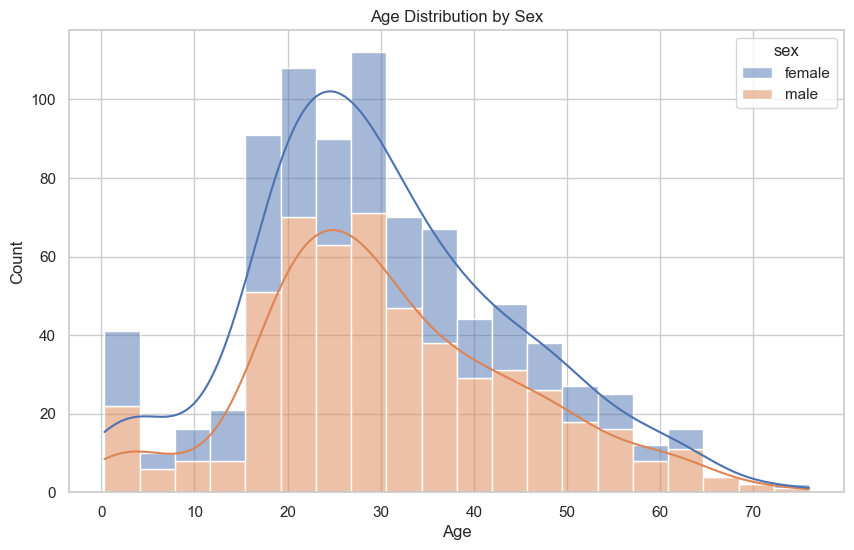

In [16756]:
plt.figure(figsize=(10, 6))

sns.histplot(train_df, x='age', hue='sex', multiple='stack', kde=True)

plt.title("Age Distribution by Sex")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/4142265806.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex_male', y='age', data=correlation_test, palette='Set2', ax=axs[0, 1])
/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/4142265806.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pclass', y='age', data=train_df, palette='Set2', ax=axs[1, 0])


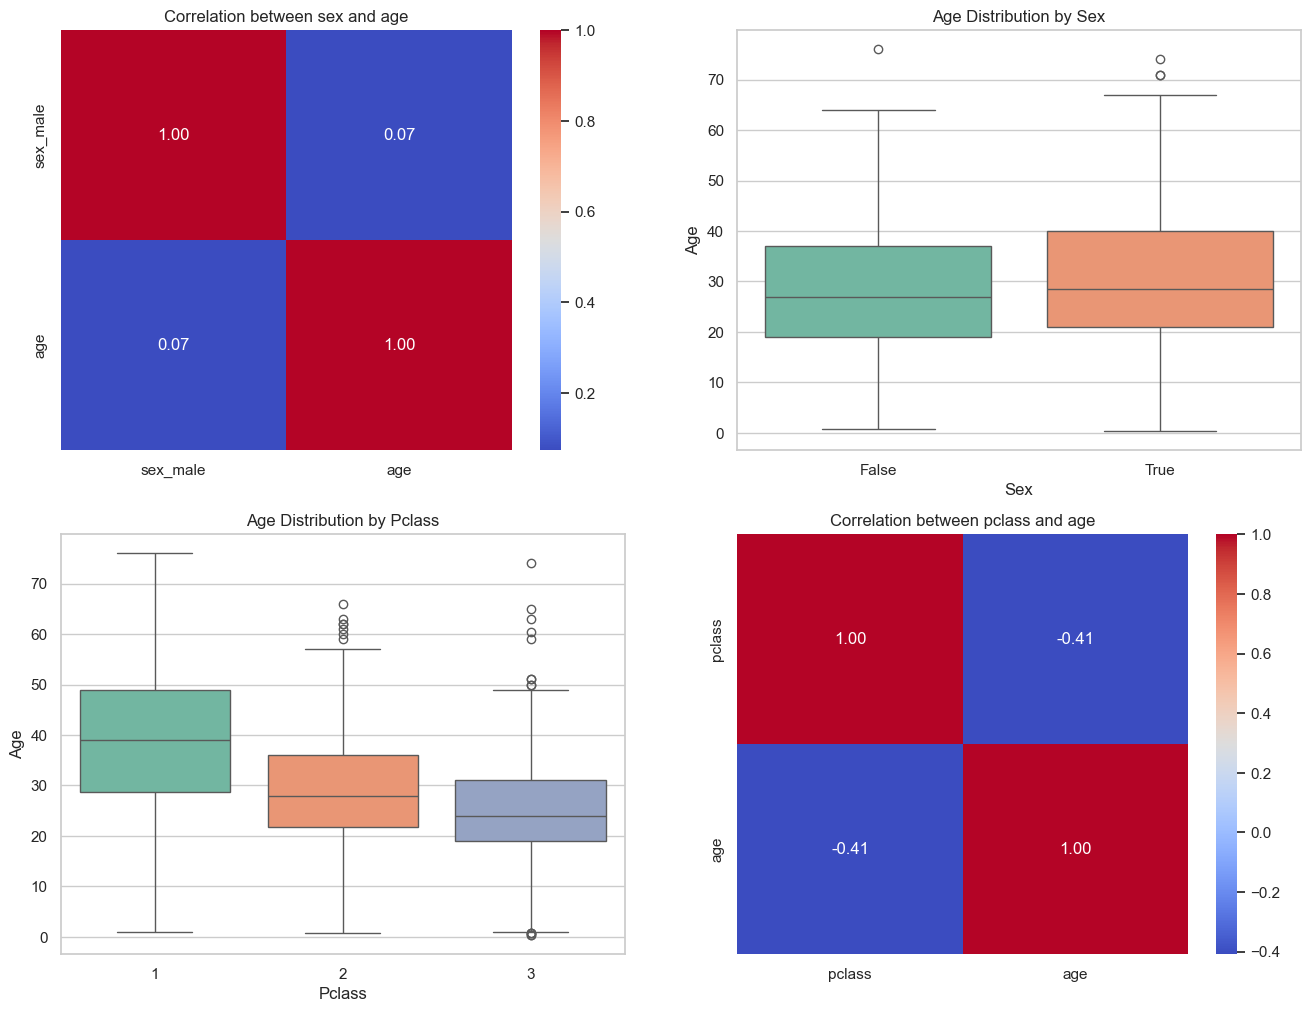

<Figure size 1000x800 with 0 Axes>

In [16757]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

#Correlation Matrix for sex-age
#copy of original dataset to avoid early modifications
correlation_test = train_df.copy()

correlation_test = pd.get_dummies(correlation_test, columns=['sex'], drop_first=True)
selected_columns = ['sex_male', 'age']
df_selected = correlation_test[selected_columns]
correlation_matrix = df_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title('Correlation between sex and age')


#Boxplot for sex-age
sns.boxplot(x='sex_male', y='age', data=correlation_test, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Age Distribution by Sex')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Age')

#Boxplot pclass-age

sns.boxplot(x='pclass', y='age', data=train_df, palette='Set2', ax=axs[1, 0])
axs[1, 0].set_title('Age Distribution by Pclass')
axs[1, 0].set_xlabel('Pclass')
axs[1, 0].set_ylabel('Age')


#Correlation Matrix pclass-age
selected_columns = ['pclass', 'age']
df_selected = train_df[selected_columns]
correlation_matrix = df_selected.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axs[1, 1])
axs[1, 1].set_title('Correlation between pclass and age')

plt.tight_layout()
plt.show()


In [16758]:
#MEAN BY PCLASS

mean_age_by_pclass = train_df.groupby('pclass')['age'].mean()

for pclass in mean_age_by_pclass.index:  
    train_df.loc[(train_df['pclass'] == pclass) & (train_df['age'].isnull()), 'age'] = mean_age_by_pclass[pclass]
    validation_df.loc[(validation_df['pclass'] == pclass) & (validation_df['age'].isnull()), 'age'] = mean_age_by_pclass[pclass]
    test_df.loc[(test_df['pclass'] == pclass) & (test_df['age'].isnull()), 'age'] = mean_age_by_pclass[pclass]

print("Missing values:")
print("Train:", train_df['age'].isnull().sum())  
print("Validation:", validation_df['age'].isnull().sum())  
print("Test:", test_df['age'].isnull().sum())  


Missing values:
Train: 0
Validation: 0
Test: 0


## 5. Encoding Categorical Variables -> VER LA FUNCION DE TITLE

The following section handles the encoding of categorical variables, this is the process of converting them into numeric features ensuring they can be properly interpreted by the model.

The current training, validation and testing sets consist of the following categorical variables:

- pclass (Ordinal Categorical):

No encoding will be performed on pclass for the following reason:
There is a clear rank of categories where pclass 1 is the highest class (first class), followed by pclass 2 (second class), and then pclass 3 (third class). The values 1, 2, and 3 are already ordered numerically so there is no need to apply an encoding method like OrdinalEncoder. It follows that the model performance is the same with and without this extra step, which would only add complexity. 

- survived (Binary Categorical):

Since survived is already binary (1, 0) no encoding will be performed.


- sex, embarked, name (Nominal Categorical):

The encoding of these remaining variables will be explained in senctions 5.1, 5.2, 5.3 respectively.

- cabin:

Cabin is originally presented as a Nominal Category. However, after analysis and extraction of decks we could conclude it has become an Ordinal Categorical Variable. The encoding decision is presented in section 5.2.



#### 5.1 Sex and Embarked

Sex and embarked are encoded using OneHotEncoder. 

Both variables are nominal, which means their categories do not have a natural ranking. Moreover, both features have a pretty low cardinality (2 for sex and 3 for embarked) so creating a separate binary column for each category will not significantly increase the dimensionality of the dataset or computational complexity.


In [16759]:
unique_embarked = train_df['embarked'].nunique()
unique_sex = train_df['sex'].nunique()

print(f"Number of unique values for embarked: {unique_embarked}")
print(f"Number of unique values for sex: {unique_sex}")

Number of unique values for embarked: 3
Number of unique values for sex: 2


The OneHotEncoder handle_unknown parameter is set to 'ignore'. This is used to handle cases where new categories appear in the validation or test sets and are not present during training. This happens because of the data splitting being performed in a previous step.
Setting it to ignore allows unknown categories to be represented as zeros, ensuring there are no raised errors when the model receives an unseen category during prediction.

The drop parameter is set to 'first' which drops the category in each feature to avoid multicollinearity.
Since the presence of one category (1) can be determined if all the others are 0s then it is redundant to include all categories.


In [16760]:
one_hot_cols = ["sex", "embarked"]  
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  

#stores the unique categories from the training datase /  possible values for each categorical column
ohe.fit(train_df[one_hot_cols])

#Convert into one-hot
train_ohe = ohe.transform(train_df[one_hot_cols])
validation_ohe = ohe.transform(validation_df[one_hot_cols])
test_ohe = ohe.transform(test_df[one_hot_cols])

#dataframe manipulation
ohe_cols = ohe.get_feature_names_out(one_hot_cols)
train_ohe = pd.DataFrame(train_ohe, columns=ohe_cols, index=train_df.index)
validation_ohe = pd.DataFrame(validation_ohe, columns=ohe_cols, index=validation_df.index)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_cols, index=test_df.index)

train_df = train_df.drop(columns=one_hot_cols).join(train_ohe)
validation_df = validation_df.drop(columns=one_hot_cols).join(validation_ohe)
test_df = test_df.drop(columns=one_hot_cols).join(test_ohe)


#### 5.2 Cabin

As shown in Section 2.3, a relationship between pclass and cabin letter has been deduced. In order to enhance this conviction further research has been done.
The following webpage clearly states the rank and distribution of cabins across the different classes of passengers:

https://www.encyclopedia-titanica.org/titanic-deckplans/

This source confirms that the Titanic's cabins were indeed segregated by passenger class, with first-class passengers occupying the more premium cabins on the upper decks, while second-class passengers were located on the middle decks, and third-class passengers were assigned to the lower decks. 

In order to get meaningful insights from the feature, the first letter in the cabin number will be extracted.
Due to this ranking of cabin letters, Ordinal Encoding will be used. This preserves the ordinal nature of the variable, which helps the model understand the order between categories.  

It is also more efficient than One Hot Encoding because it only creates a single integer column per feature rather than binary columns per category.

LabelEncoding was also considered, however, scikit-learn documentation indicates that this transformer should be used to encode target values and not the input.


The value -1 in the parameter unknown_value is used for those categories that might be present in the validation or test sets but not during training. So that if an unknown category appears during the transformation of the validation or test sets no errors are raised.

In [16761]:
train_df['cabin'] = train_df['cabin'].str[0]
validation_df['cabin'] = validation_df['cabin'].str[0]
test_df['cabin'] = test_df['cabin'].str[0]

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df['cabin'] = ordinal_encoder.fit_transform(train_df[['cabin']])
validation_df['cabin'] = ordinal_encoder.fit_transform(validation_df[['cabin']])
test_df['cabin'] = ordinal_encoder.fit_transform(test_df[['cabin']])

In [16762]:
train_df.head()

,pclass,survived,name,age,sibsp,parch,cabin,sex_male,embarked_Q,embarked_S
829,3,0,"Goodwin, Miss. Lillian Amy",16.000000,5,2,7.0,0.0,0.0,1.0
889,3,1,"Johansson Palmquist, Mr. Oskar Leander",26.000000,0,0,7.0,1.0,0.0,1.0
330,2,0,"Ashby, Mr. John",57.000000,0,0,7.0,1.0,0.0,1.0
91,1,1,"Dick, Mr. Albert Adrian",31.000000,1,0,1.0,1.0,0.0,1.0
808,3,0,"Ford, Mr. Arthur",24.913917,0,0,7.0,1.0,0.0,1.0


In [16763]:
train_df_copy = df.copy() #later used plots

For cabin we extract the first letter and encode it since it means the deck where it was located
As seen in the overview cabin has 186 unique values.
It follows that Unknown will be cabin_U

With 186 unique values, one-hot encoding will create 186 new columns, which can significantly increase the dimensionality of your dataset. This is problematic for algorithms that suffer from the "curse of dimensionality," like linear models or models with regularization (like Lasso or Ridge regression).


In [16764]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,C22 C26,S


#### 5.3 Name

The Name variable is unique to each passenger and lacks generalizability. However, the title, extracted, which appears before the first period in the name, provides valuable information about social status and demographics in general, which can be generalized across different datasets. 

Because of this the name feature will be dropped and a new column called title will be added and encoded.

In order to extract the title from the name feature, a regular expression is used to find the word before the first . 

In [16765]:
# Function to extract title from feature name 
def extract_title(name):
    # regex expression -> find the word before the . 
    title = re.findall(r'([A-Za-z]+)\.', name)
    return title[0] if title else None  


train_df['title'] = train_df['name'].apply(extract_title)
validation_df['title'] = validation_df['name'].apply(extract_title)
test_df['title'] = test_df['name'].apply(extract_title)

train_df.head(5)


,pclass,survived,name,age,sibsp,parch,cabin,sex_male,embarked_Q,embarked_S,title
829,3,0,"Goodwin, Miss. Lillian Amy",16.000000,5,2,7.0,0.0,0.0,1.0,Miss
889,3,1,"Johansson Palmquist, Mr. Oskar Leander",26.000000,0,0,7.0,1.0,0.0,1.0,Mr
330,2,0,"Ashby, Mr. John",57.000000,0,0,7.0,1.0,0.0,1.0,Mr
91,1,1,"Dick, Mr. Albert Adrian",31.000000,1,0,1.0,1.0,0.0,1.0,Mr
808,3,0,"Ford, Mr. Arthur",24.913917,0,0,7.0,1.0,0.0,1.0,Mr


In [16766]:
train_df.tail(5)

,pclass,survived,name,age,sibsp,parch,cabin,sex_male,embarked_Q,embarked_S,title
848,3,0,"Hansen, Mr. Claus Peter",41.000000,2,0,7.0,1.0,0.0,1.0,Mr
610,3,0,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",40.000000,1,0,7.0,0.0,0.0,1.0,Mrs
788,3,0,"Ekstrom, Mr. Johan",45.000000,0,0,7.0,1.0,0.0,1.0,Mr
1124,3,0,"Peters, Miss. Katie",24.913917,0,0,7.0,0.0,1.0,0.0,Miss
511,2,0,"Myles, Mr. Thomas Francis",62.000000,0,0,7.0,1.0,1.0,0.0,Mr


In [16767]:
#check if any missing values were left
missing_values_count = train_df['title'].isnull().sum()
print(missing_values_count) 

0


In [16768]:
#number of different titles 
train_df['title'].nunique()

13

In [16769]:
train_df['title'].unique()

array(['Miss', 'Mr', 'Mrs', 'Dr', 'Rev', 'Master', 'Mme', 'Jonkheer',
       'Dona', 'Col', 'Sir', 'Ms', 'Mlle'], dtype=object)

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/2570695372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='title', data=train_df, palette=['lightgreen'])


Text(0.5, 1.0, 'Title Box Plot')

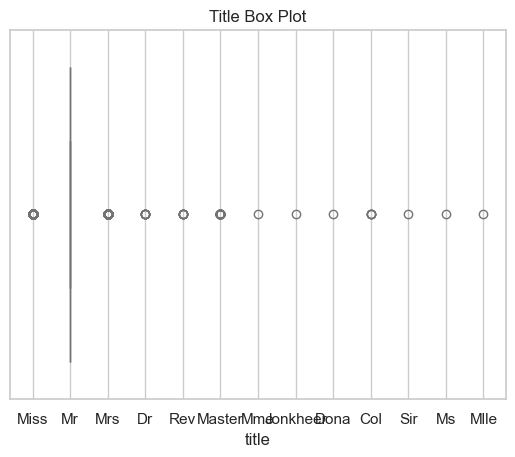

In [16770]:
#boxplot 
sns.boxplot(x='title', data=train_df, palette=['lightgreen'])
plt.title('Title Box Plot')

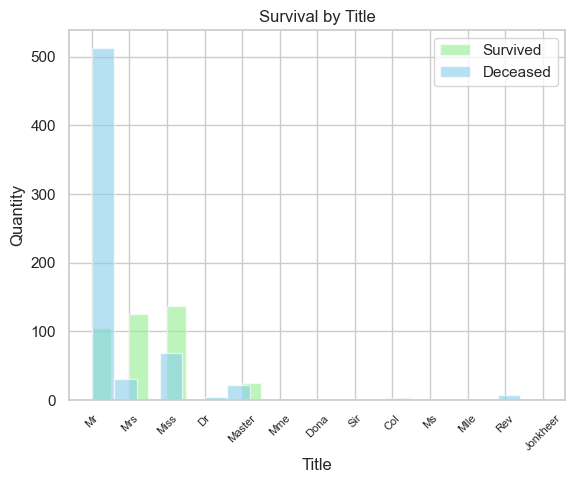

In [16771]:
plt.hist(train_df[train_df['survived'] == 1]['title'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

plt.hist(train_df[train_df['survived'] == 0]['title'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')


plt.xlabel('Title')
plt.ylabel('Quantity')
plt.title('Survival by Title')
plt.legend()
plt.xticks(rotation = 45, fontsize=8)
plt.show()

In [16772]:
title_counts = train_df['title'].value_counts()
print(title_counts)


title
Mr          617
Miss        205
Mrs         156
Master       45
Dr            7
Rev           7
Col           4
Mme           1
Jonkheer      1
Dona          1
Sir           1
Ms            1
Mlle          1
Name: count, dtype: int64


Due to the high number of rare titles (many even with a frequency of only 1), and in order to achieve efficiency in encoding and simplify the model, these will be grouped under a new category called "Others" by the following function created with chatgpt.

In [16773]:
#Handling outliers
outlier_threshold = 5  

#outliers in train set (those with counts lower than the set threshold)
outliers_train = title_counts[title_counts < outlier_threshold]
outlier_titles = set(outliers_train.index) 

# Identifying rare titles in validation and test sets and adding them to the list 
for df in [validation_df, test_df]:
    rare_titles_in_df = df["title"].value_counts()[df["title"].value_counts() < outlier_threshold].index
    outlier_titles.update(rare_titles_in_df)  # Add validation/test outliers

# 🔍 Debug: Print Final List of Titles to be Replaced
print("\nOutlier Titles (to be replaced with 'Others'):\n", outlier_titles)

# Replace with Others in all datasets
for df in [train_df, validation_df, test_df]:
    df.loc[df['title'].isin(outlier_titles), 'title'] = 'Others'


print("\nTitles in Train Dataset:")
print(train_df['title'].value_counts(), "\n")

print("Titles in Validation Dataset:")
print(validation_df['title'].value_counts(), "\n")

print("Titles in Test Dataset:")
print(test_df['title'].value_counts(), "\n")



Outlier Titles (to be replaced with 'Others'):
 {'Jonkheer', 'Sir', 'Dona', 'Mlle', 'Countess', 'Rev', 'Major', 'Mme', 'Capt', 'Lady', 'Col', 'Don', 'Dr', 'Ms'}

Titles in Train Dataset:
title
Mr        617
Miss      205
Mrs       156
Master     45
Others     24
Name: count, dtype: int64 

Titles in Validation Dataset:
title
Mr        72
Miss      28
Mrs       17
Master     9
Others     5
Name: count, dtype: int64 

Titles in Test Dataset:
title
Mr        68
Miss      27
Mrs       24
Master     7
Others     5
Name: count, dtype: int64 



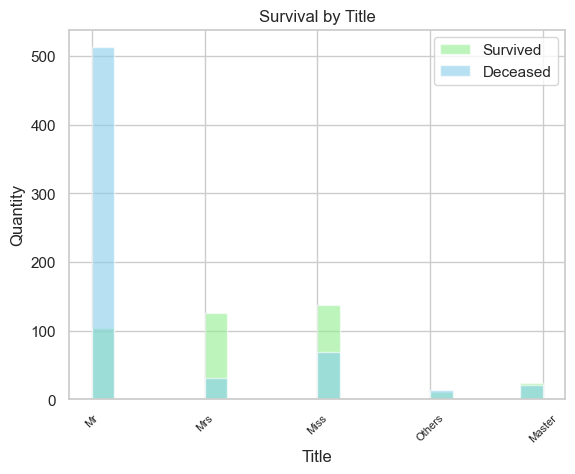

In [16774]:
plt.hist(train_df[train_df['survived'] == 1]['title'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

plt.hist(train_df[train_df['survived'] == 0]['title'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')

plt.ylabel('Quantity')
plt.xlabel('Title')
plt.title('Survival by Title')
plt.legend()
plt.xticks(rotation = 45, fontsize=8)
plt.show()

In [16775]:
#drop feature name from datasets
train_df = train_df.drop(columns=['name'])
validation_df = validation_df.drop(columns=['name'])
test_df = test_df.drop(columns=['name'])

One Hot Encoding will be used since there is no ordinal relationships, treating each category as independent features.

In [16776]:
#OneHotEncoding
ohe_title = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

ohe_title.fit(train_df[['title']])

train_title_ohe = ohe_title.transform(train_df[['title']])
validation_title_ohe = ohe_title.transform(validation_df[['title']])
test_title_ohe = ohe_title.transform(test_df[['title']])

# Convert transformed arrays into DataFrames with correct column names
title_ohe_cols = ohe_title.get_feature_names_out(['title'])

train_title_ohe = pd.DataFrame(train_title_ohe, columns=title_ohe_cols, index=train_df.index)
validation_title_ohe = pd.DataFrame(validation_title_ohe, columns=title_ohe_cols, index=validation_df.index)
test_title_ohe = pd.DataFrame(test_title_ohe, columns=title_ohe_cols, index=test_df.index)

# Drop original `title` column and merge the one-hot encoded columns
train_df = train_df.drop(columns=['title']).join(train_title_ohe)
validation_df = validation_df.drop(columns=['title']).join(validation_title_ohe)
test_df = test_df.drop(columns=['title']).join(test_title_ohe)

In [16777]:
train_df.head()

,pclass,survived,age,sibsp,parch,cabin,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Others
829,3,0,16.000000,5,2,7.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
889,3,1,26.000000,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
330,2,0,57.000000,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
91,1,1,31.000000,1,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
808,3,0,24.913917,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## 6. Feature scaling 

This step is critical to ensure all numerical features contribute equally towards the model's performance and that none affect it disproportionately their because of their greater range or magnitude.

Currently, age, sibsp, parch and pclass should be processed.

Although pclass is an ordinal categorical variable, logistic regression models often perform better when the features are on a similar scale. So scaling it may help the model avoid giving it disproportionate weight relative to other features.

In [16778]:
train_df.head()

,pclass,survived,age,sibsp,parch,cabin,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Others
829,3,0,16.000000,5,2,7.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
889,3,1,26.000000,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
330,2,0,57.000000,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
91,1,1,31.000000,1,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
808,3,0,24.913917,0,0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


#### 6.1 Sibsp and Parch

For sibsp and parch, which stands for siblings / spouses and parents / children, a correlation check will be held since they are likely correlated as they both represent family and families often travel together. 

We expect a positive correlation. If this is the case, in order to avoid multicollinearity, which makes it hard for the model to determine the independent contribution of each feature, both features will be combined into a unique one named family.size. Family.size will capture both contributions into a single varibale.

In [16779]:
# Ccorrelation between 'sibsp' and 'parch'
correlation = train_df[['sibsp', 'parch']].corr()

print(correlation)


         sibsp    parch
sibsp  1.00000  0.34081
parch  0.34081  1.00000


The correlation coefficient between sibsp and parch is 0.34, which indicates a low to moderate positive correlation between the two features. 
While they are not highly correlated, this suggests that there is some relationship between the number of siblings/spouses and the number of parents/children aboard.

Given this moderate correlation, it seems reasonable to combine sibsp and parch into the mentioned feature family.size.


In [16780]:
train_df['family.size'] = train_df['sibsp'] + train_df['parch'] + 1
train_df = train_df.drop(columns = ['sibsp', 'parch'])
train_df.head()

,pclass,survived,age,cabin,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Others,family.size
829,3,0,16.000000,7.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,8
889,3,1,26.000000,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
330,2,0,57.000000,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
91,1,1,31.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2
808,3,0,24.913917,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1


In [16781]:
validation_df['family.size'] = validation_df['sibsp'] + validation_df['parch'] + 1
validation_df = validation_df.drop(columns = ['sibsp', 'parch'])

test_df['family.size'] = test_df['sibsp'] + test_df['parch'] + 1
test_df = test_df.drop(columns = ['sibsp', 'parch'])

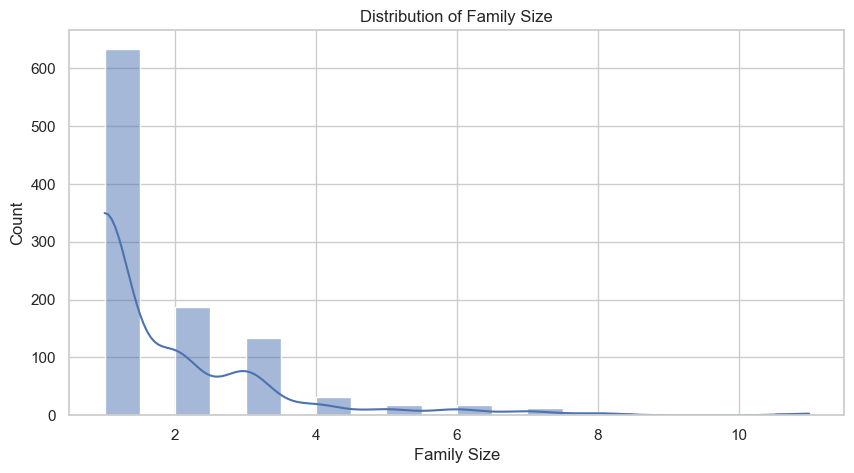

In [16782]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['family.size'], bins=20, kde=True)
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.title("Distribution of Family Size")
plt.show()

#### 6.2 Standardization

For feature scaling two different approaches are considered: Standardization and Normalization.

Standardization brings the features to a common scale with mean 0 and standard deviation 1. This is done by subtracting the mean of each feature from the data points and dividing by the standard deviation. This can be applied using StandaredScaler. 

Normalization transforms the features into a specific range such as [0,1]. This is done by subtracting the minimum value of the feature and dividing by the range (maximum - minimum). This can be applied using MinmaxScaler.

While standardization usually works better with normally distributed data, normalization usually works better with uniformly distributed data.

Standardization is used to ensure that features have the same scale, especially when they have different magnitudes.
Normalization is typically used when the data needs to be in a specific range. It generally performs well on algorithms that use distances, such as K-Nearest Neighbors (KNN). 

One of the biggest impacts to consider regarding these methods is their impact on the data distribution:
Standardization does not change the distribution of the data. Standardization only changes the spread and center of the data. Normalization, on the other hand, forces the data into a fixed range. This could compress large values or extreme outliers into a small range, leading to potential information loss and affecting model performance.

This also makes Standardization less sensitive to outliers than normalization, which may cause the latter to hide underlying patterns in the data.

Standardization is preferred over normalization for this dataset because it ensures that all features are on the same scale with a mean of 0 and a standard deviation of 1, which is crucial for Logistic Regression, a linear model sensitive to feature scales. Standardization improves the model’s convergence during gradient descent optimization by allowing each feature to contribute equally, preventing larger scale features from disproportionately influencing the model. Additionally, standardization is less sensitive to outliers compared to normalization, which can distort the data when outliers are present. Since standardization uses the mean and standard deviation, it retains the spread and variance of the data, ensuring that outliers, such as those in the family.size variable, remain identifiable without compressing the data into a narrow range. 

Since the method of standardization is based on central tendencies and variance of data it must be applied after data splitting in order to avoid data leackage.

In [16783]:
num_features = ["family.size", "pclass", "age"]  

scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])
validation_df[num_features] = scaler.fit_transform(validation_df[num_features])
test_df[num_features] = scaler.fit_transform(test_df[num_features])

train_df.head(5)

,pclass,survived,age,cabin,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Others,family.size
829,0.857185,0,-1.036227,7.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.212663
889,0.857185,1,-0.264901,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.573356
330,-0.333097,0,2.126212,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.573356
91,-1.523379,1,0.120763,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.110361
808,0.857185,0,-0.348673,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.573356


#### 6.3 Interaction

Creating an interaction term between age and pclass helps the model capture more complex relationships between these two features and their combined effect on the target variable.
It allows the model to account for situations where the influence of age on survival depends on pclass, which might not be captured if the features are treated independently.

In [16784]:
#since age and pclass are already standardized there is no need to reapply
train_df['age_pclass_interaction'] = train_df['age'] * train_df['pclass']
validation_df['age_pclass_interaction'] = validation_df['age'] * validation_df['pclass']
test_df['age_pclass_interaction'] = test_df['age'] * test_df['pclass']

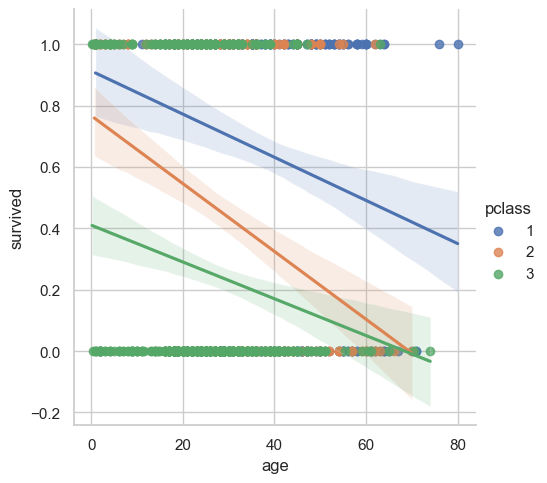

In [16785]:
sns.lmplot(x="age", y="survived", hue="pclass", data=train_df_copy)
plt.show()


The lines for each pclass are not parallel, indicating that the relationship between age and survival changes depending on pclass. 
This suggests an interaction effect: the impact of age on survival differs across the levels of pclass.

## 7. Feature and Target Division

This step involves separating independent variables (input) from the target (output) for the model to learn from the input and predict the output.

Since the target remained unaffected by preprocessing steps and the transformations were carefully applied to the features and not the target

the order of splitting the data into features(x) and target(y) sets does not affect the integrity of the process. 

In [16786]:
# Feature and Target division
x_train = train_df.drop(columns=['survived'])
y_train = train_df['survived']

x_val = validation_df.drop(columns=['survived'])
y_val = validation_df['survived']

x_test = test_df.drop(columns=['survived'])
y_test = test_df['survived']

## 8. Addressing Class Imbalance

Logistic Regression can still perform well with class imbalance. 
In this case, the model has proved to be able to learn the patterns in the data without requiring additional techniques to balance the classes, such as SMOTE or ADASYN.

In fact, many times, they led to a lower accuracy result, probably because of underfitting/overfitting.
Therefore, in this case, it seemed better to stick with the raw data. Since I am avoiding unneccessary steps, allowing the model to learn from the data in its original form. 

*note: this decision has been revisited depending on the model's performance.


In [16787]:
#smote
#smote = SMOTE(sampling_strategy='auto', random_state=2025, k_neighbors=5)
#x_train, y_train = smote.fit_resample(x_train, y_train)

In [16788]:
#adasyn
#adasyn = ADASYN(sampling_strategy='auto', random_state=2025)
#x_train, y_train = adasyn.fit_resample(x_train, y_train)


## 9. Feature Selection

In this section low variance and highly correlated features will be removed. 

 Feature Selection
 Addressing Class Imbalance

Why do we carry out tasks 6 and 7 after splitting the dataset into training, validation, and test sets? Could
we have conducted them on the entire dataset instead? Please elaborate on your answer.

Porque feature selection after splitting

#### HeatMap

In [16789]:
#Ver si tengo que hacer todo el correlation map y eso con los datos despues de adasyn y smote o antes

En lugar de crear muchas columnas para cada letra de cabina, puedes agrupar las cabinas en categorías más generales que tengan sentido para tu análisis. Por ejemplo:

Primera clase, segunda clase, tercera clase (si las cabinas están relacionadas con la clase del pasajero).
Cabinas cercanas al puente (A, B, C) y cabinas más alejadas (D, E, F, etc.).
Cabinas con "Unknown" (para aquellas sin un valor claro).

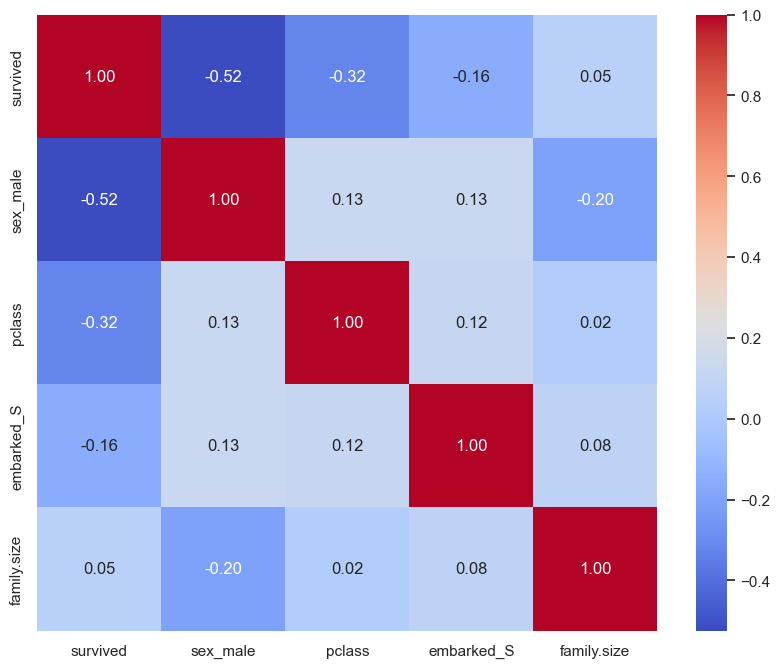

In [16790]:
# Lista de columnas que deseas incluir en el heatmap
selected_columns = ['survived', 'sex_male', 'pclass', 'embarked_S', 'family.size']
#selected_columns += [col for col in df.columns if col.startswith('title_')]

# Seleccionar solo las columnas de interés
df_selected = train_df[selected_columns]

# Calcular la matriz de correlación entre las columnas seleccionadas
correlation_matrix = df_selected.corr()

# Visualizar la matriz de correlación con un heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


Since pclass is hoghly correlated with fare and more correlated with survived than fare -> drop fare
Pero pclass esta mas correlated con cabin que fare
parch is also pretty correlated with sibsp -> put together

WHY DROPPING FARE?

1. pclass is more correlated with survived than fare

Since your goal is to predict survival, you should keep the features that have the strongest correlation with survived.

If pclass has a higher correlation with survived than fare, then pclass is likely the more important predictor.

2. pclass is also more correlated with cabin

If pclass is highly correlated with cabin, this suggests that pclass captures important structural information about where passengers were located on the ship.

cabin itself is an important feature because higher-class passengers were likely to have better access to lifeboats.

3. Multicollinearity Issue
If fare and pclass are highly correlated, including both could introduce multicollinearity, which can make models unstable and harder to interpret.

Since pclass is categorical and represents a clear distinction between socioeconomic groups, it is often more informative than fare, which can have more variability and outliers.



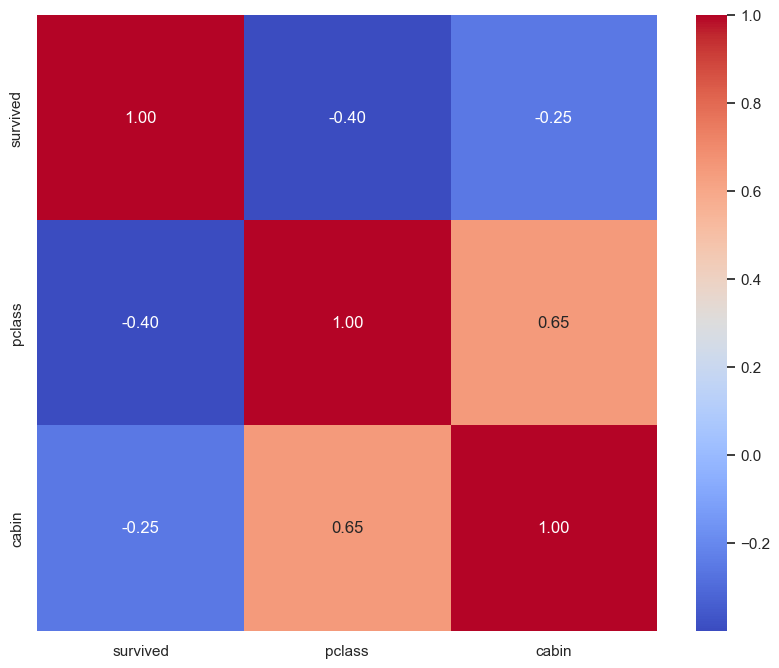

In [16791]:
selected_columns = ['survived', 'pclass', 'cabin']
#selected_columns += [col for col in df.columns if col.startswith('cabin_')]

df_selected = df[selected_columns]

# Calcular la matriz de correlación entre las columnas seleccionadas
correlation_matrix = df_selected.corr()

# Visualizar la matriz de correlación con un heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


#### PClass

In [16792]:
#Percentage of Survival within each Cabin
survival_percentage_by_cabin = df_copy.groupby('cabin')['survived'].mean() * 100
print(survival_percentage_by_cabin)

cabin
A    50.000000
B    72.307692
C    60.638298
D    69.565217
E    73.170732
F    61.904762
G    60.000000
T     0.000000
U    30.276134
Name: survived, dtype: float64


El porcentaje de supervivientes en cuanto al total marcado por grupo

All but two lifeboats were situated on the Boat Deck, the highest deck of Titanic. 
-Wikipedia

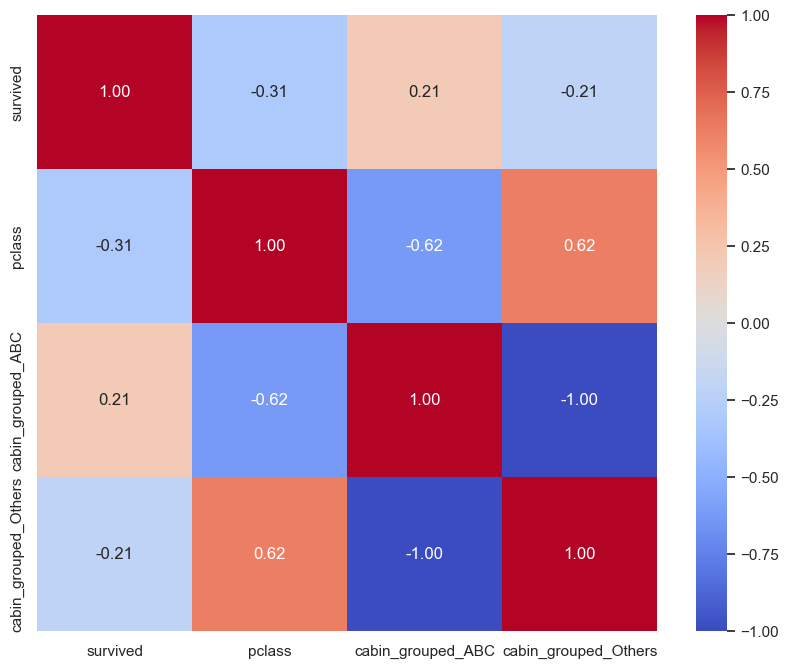

In [16793]:
df_copy['cabin_grouped'] = np.where(df_copy['cabin'].isin(['A', 'B', 'C']), 'ABC', 'Others')

# Step 2: Perform One-Hot Encoding for 'cabin_grouped'
df_copy_encoded = pd.get_dummies(df_copy, columns=['cabin_grouped'], drop_first=False)

# Step 3: Select the columns of interest (including 'survived' and the encoded 'cabin_grouped')
selected_columns = ['survived', 'pclass'] + [col for col in df_copy_encoded.columns if col.startswith('cabin_grouped_')]

df_selected = df_copy_encoded[selected_columns]

# Step 4: Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [16794]:
# Compute variance of all numerical features
numerical_features = x_train.select_dtypes(include=['number'])  # Select only numeric features
feature_variances = numerical_features.var()

# Print the variance of each feature
print("Feature Variances:\n", feature_variances)


Feature Variances:
 pclass                    1.000956
age                       1.000956
cabin                     4.329767
sex_male                  0.227588
embarked_Q                0.081798
embarked_S                0.209779
title_Miss                0.157611
title_Mr                  0.242256
title_Mrs                 0.126918
title_Others              0.022419
family.size               1.000956
age_pclass_interaction    1.053176
dtype: float64


In [16795]:
#Eliminate low variance features
var_thresh = VarianceThreshold(threshold=0.03) 

var_thresh.fit(numerical_features)

low_variance_features = numerical_features.columns[~var_thresh.get_support()]  # Use `~` to get False values

x_train.drop(columns=low_variance_features, inplace=True)
x_val.drop(columns=low_variance_features, inplace=True)
x_test.drop(columns=low_variance_features, inplace=True)

print("Low variance features removed:", low_variance_features)

Low variance features removed: Index(['title_Others'], dtype='object')


In [16796]:
# VIF Calculation 
# intercept term
X = add_constant(x_train)  

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature         VIF
0                    const  224.120123
1                   pclass    2.620651
2                      age    1.732984
3                    cabin    2.276131
4                 sex_male   53.034259
5               embarked_Q    1.523097
6               embarked_S    1.468162
7               title_Miss   34.374444
8                 title_Mr    5.445997
9                title_Mrs   27.858604
10             family.size    1.271748
11  age_pclass_interaction    1.259886


In [16797]:
x_train.drop(columns=['title_Miss', 'sex_male', 'title_Mrs'], inplace=True)
x_val.drop(columns=['title_Miss', 'sex_male', 'title_Mrs'], inplace=True)
x_test.drop(columns=['title_Miss', 'sex_male', 'title_Mrs'], inplace=True)

In [16798]:
x_train.head()

,pclass,age,cabin,embarked_Q,embarked_S,title_Mr,family.size,age_pclass_interaction
829,0.857185,-1.036227,7.0,0.0,1.0,0.0,4.212663,-0.888238
889,0.857185,-0.264901,7.0,0.0,1.0,1.0,-0.573356,-0.227069
330,-0.333097,2.126212,7.0,0.0,1.0,1.0,-0.573356,-0.708235
91,-1.523379,0.120763,1.0,0.0,1.0,1.0,0.110361,-0.183967
808,0.857185,-0.348673,7.0,0.0,1.0,1.0,-0.573356,-0.298877


## 10. Training a Logistic Regression Model

In [16799]:
'''
model = LogisticRegression(max_iter=1000)  
model.fit(x_train, y_train)

y_pred = model.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")  # Display accuracy up to 4 decimal places

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
'''


'\nmodel = LogisticRegression(max_iter=1000)  \nmodel.fit(x_train, y_train)\n\ny_pred = model.predict(x_test)\n\n\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy}")  # Display accuracy up to 4 decimal places\n\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred))\n'

In [16806]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

y_pred_prob = model.predict_proba(x_test)[:, 1]

threshold = 0.6

y_pred = (y_pred_prob >= threshold).astype(int)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8625954198473282
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        81
           1       0.82      0.82      0.82        50

    accuracy                           0.86       131
   macro avg       0.85      0.85      0.85       131
weighted avg       0.86      0.86      0.86       131

Confusion Matrix:
[[72  9]
 [ 9 41]]


#### 10.1 Confusion Matrix

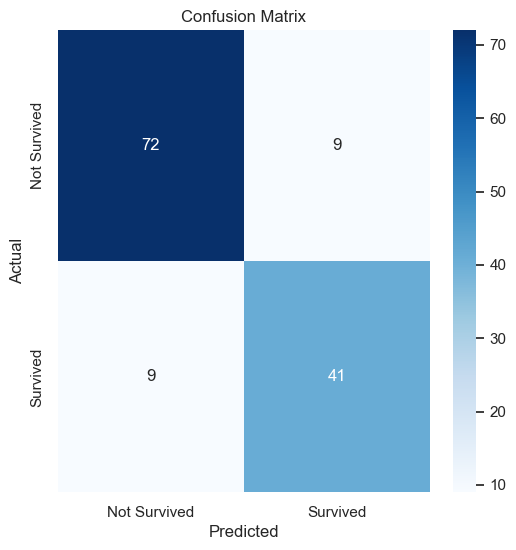

In [16801]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### 10.2 Table of predicted vs actual classifications

In [16808]:
# Predicted probabilities (probabilities for class 1, survival)

predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Predicted_Probability': y_pred_prob
})

print(predicted_vs_actual.head(20)) 


      Actual  Predicted  Predicted_Probability
144        1          1               0.950356
1177       0          0               0.025259
116        1          1               0.658536
620        0          0               0.110966
583        1          1               0.748225
1295       0          0               0.123703
753        0          0               0.122495
63         1          1               0.827467
838        0          0               0.085769
438        1          1               0.731832
1175       0          0               0.259783
551        1          1               0.696947
428        1          1               0.762978
221        0          0               0.299155
790        0          0               0.120557
185        0          0               0.280256
457        0          0               0.207959
560        1          1               0.793398
506        0          0               0.092304
478        1          1               0.890506


#### 10.3 ROC Curve

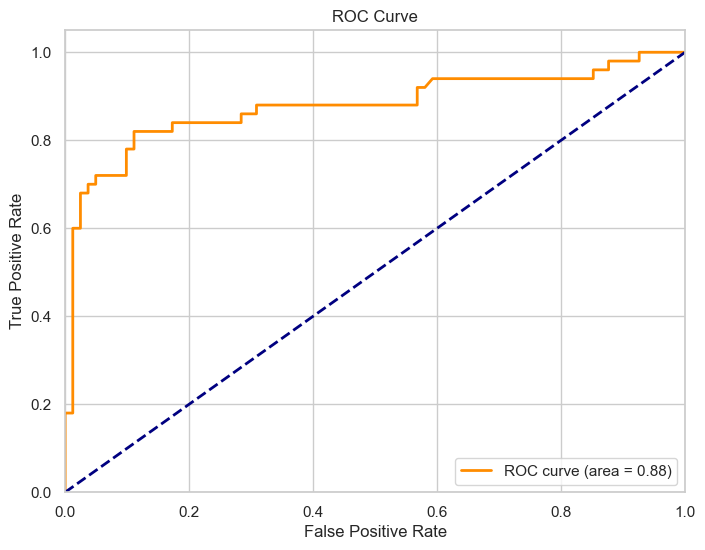

In [16809]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


#### 10.5 Distribution of predicted survival probabilities 

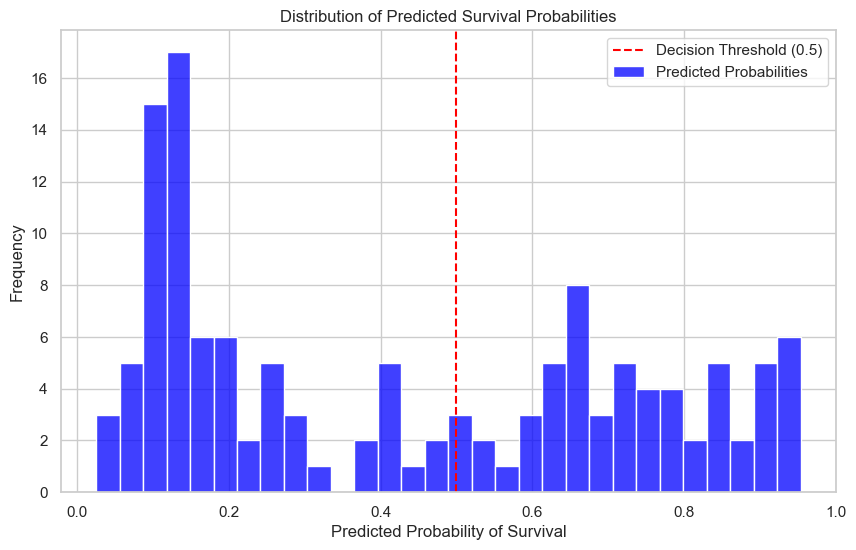

In [16804]:
plt.figure(figsize=(10, 6))

sns.histplot(y_pred_prob, bins=30, kde=False, color='blue', label='Predicted Probabilities')

# Add the decision threshold line at 0.5
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')

plt.title('Distribution of Predicted Survival Probabilities')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Frequency')


plt.legend()
plt.show()


validation set -> predict survival probabilities

BASELINE


MOSTRAR CON GRAPHS

iNTERPRET RESULTS 

ROC CURVE 
CONFUSION MATRIX 

SUMMARY 


PLOT QUE MUESTRE EL THRESHOLD